# Prediction of Snow Water Equivalent using Transformer and LSTM

### Motivation

Reference - [`Paper Ref` ](https://hess.copernicus.org/preprints/hess-2020-566/hess-2020-566.pdf).

 In the Northern Hemisphere, the seasonal snow cover is a significant factor in the global climate system. Thus snow cover is an essential variable in climate models. Previously, they found substantial uncertainties in Northern Hemisphere snow water equivalent (SWE) estimates. Snowmelt plays a significant role in the hydrological cycle of many world regions. For example, Casson et al. (2018) found that snow accumulation and melt are the main drivers of the spring freshet in the Canadian subarctic area. In addition, Pomeroy et al. (2011) showed that the snowmelt is the source of over 80% of the annual runoff in the Canadian Prairies. Therefore, an accurate prediction of the accumulation and melting of snow is vital in various applications, such as the management of reservoirs for hydroelectric power generation, irrigation and water supply, and climate impact studies. Therefore, the most commonly used parameter in hydrology is Snow water equivalent (SWE), which defines the total amount of water (solid and liquid) stored in the snowpack. However, SWE measurements are expensive and not continuously accessible in real-time; thus, the Machine learning models aid us in finding an alternative approach to predicting SWE from more widely available and continuous data.  

### Physical Model: 

Reference - [`SWE` ](https://www.climatehubs.usda.gov/hubs/northwest/topic/snow-water-equivalent-swe-its-importance-northwest#:~:text=Snow%20water%20equivalent%20(SWE)%20determines,broad%20impacts%20on%20water%20resources.). 

Snow water equivalent (SWE) determines the amount of water available in the snow. However, measuring water retained in an inch of snow is difficult to estimate since the temperature of the air controls the amount. For example, one inch of rain can produce 2 to 50 inches or more of snow, depending on the air temperature. And also, Different storms bring different types of snow that can hold different amounts of water. Throughout winter, other storms bring different types of snow, so snow depth does not translate directly to the amount of water held in snow. Because of this variability, SWE helps to understand how much water the snow contains.

<img src="images/swe_globe.png" width="300" height = "500">



### Data

Reference - [`Data Link` ](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/T46ANR).

Havard Dataverse is the data source of my project. The paper "Using an ensemble of artificial neural networks to convert snow depth to snow water equivalent over Canada. '' uses the same data. This dataset contains most of Canada's snow measurement and meteorological data. The information includes 2685 other stations or geographical locations and has sixteen features, such as  SWE(Snow Water Equivalent), Snow depth, Density, Day without snow, etc. The details of the data are below:

<img src="images/data_tab.png" width="700" height = "500">

### Approach to the problem:

Since our problem at hand is a physical model with some time series inputs and outputs. Thus, our choice of Machine learning models is LSTMs and Transformers. In various areas, the transformer is used, including NLP, time series forecasting, and so on. The transformer outperformed in terms of computation time with its parallel implementation and accuracy with the attention layer. On the other hand, Long Short-Term Memory networks, LSTMs, are a special kind of RNN introduced to mitigate the vanishing and exploding gradient problem of RNN and can learn long-term dependencies. Hence, LSTM's capability to connect previous information to the present task, like - time series forecasting, makes them suitable for many similar tasks.

### Model Performance Comparison:

In this notebook, we solely focused on the performance of each model, and there are few details of each model. But for detailed reference, please refer to the individual notebook. 

### Models:

1. Transformer
2. LSTM 


### 1. Transformer:

Reference - [`Transformer` ](https://arxiv.org/abs/1706.03762).  

Transformer architecture is constructed based on the "Attention is all I need." However, the original model is for natural language processing tasks. Thus, some unnecessary parts of the architecture are removed or replaced for the time series prediction problem. For example, the embedding layer is a simple dense layer since the input values are already numeric. However, the problem is a simple time series prediction. Thus,  I removed the decoder part.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import joblib
from sklearn import preprocessing

import matplotlib.pyplot as plt
import time
from utils.TransformerArchitecture import transformer
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, CSVLogger

from tensorflow.keras.models import load_model

import tensorflow as tf
from utils.transformer_utils import get_transformer_data
from datetime import datetime

from utils.lstm_utils import get_lstm_data
from utils.lstm import get_lstm_model
plt.rcParams.update({'font.size': 15})

In [2]:
# File paths
canada_train_data_path = "tx_data/data_filtered_train.txt"
canada_val_data_path = "tx_data/data_filtered_val.txt"
canada_test_data_path = "tx_data/data_filtered_test.txt"

In [3]:
# Transformer Data

Xt, Yt = get_transformer_data(canada_train_data_path, 10)
Xt_train, Yt_train = Xt, Yt[:,-1,:]
print(Xt_train.shape, Yt_train.shape)

Xt_v, Yt_v = get_transformer_data(canada_val_data_path, 10)
Xt_val, Yt_val = Xt_v, Yt_v[:,-1,:]
print(Xt_val.shape, Yt_val.shape)

Xt_t, Yt_t = get_transformer_data(canada_test_data_path, 10)
Xt_test, Yt_test = Xt_t, Yt_t[:,-1,:]
print(Xt_test.shape, Yt_test.shape)

(77133, 10, 15) (77133, 1)
(76827, 10, 15) (76827, 1)
(76899, 10, 15) (76899, 1)


In [4]:
input_shape = (Xt_train.shape[1],Xt_train.shape[2])

In [5]:
# Load the Transformer model
# This model is loaded using the most optimized weights
transformer_model = transformer(
    input_size = input_shape,
    num_layers = 4,
    dff = 64,
    d_model = 8,
    num_heads = 4,
    dropout = 0.0,
    name="transformer_model")
transformer_model.summary()

## model
transformer_model.load_weights('best_models/transformer_best_model.h5')
Yt_pred = transformer_model.predict(Xt_train)
Yt_test_pred = transformer_model.predict(Xt_test)

2022-12-23 16:16:22.596186: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "transformer_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 10, 15)]          0         
                                                                 
 embedding (Dense)           (None, 10, 8)             128       
                                                                 
 encoder (Functional)        [(None, 10, 8),           5664      
                              (None, 4, None, None)]             
                                                                 
 output (Dense)              (None, 10, 1)             9         
                                                                 
 tf.__operators__.getitem (S  (None, 10)               0         
 licingOpLambda)                                                 
                                                                 
Total params: 5,801
Trainable params: 5,801
Non-t

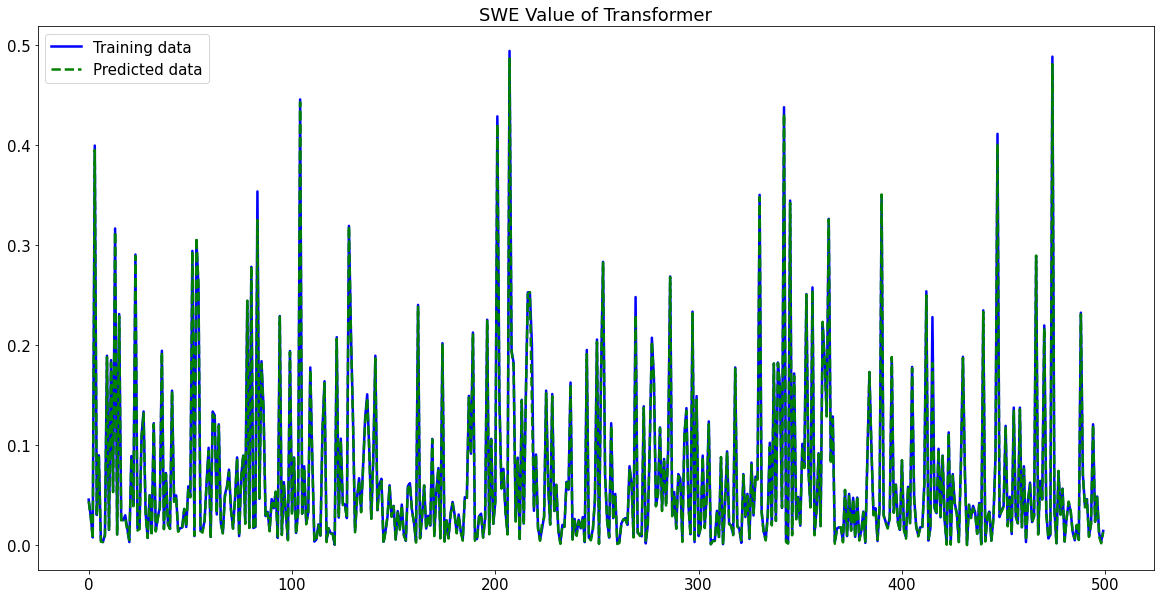

In [7]:
plt.figure(figsize=(20, 10))
# plt.plot(Y_pred[:,1], label='q_predicted')
# plt.plot(Y_train[:,1], label='q')
plt.plot(Yt_train[:500,], 'b-', linewidth=2.5, label='Training data')
plt.plot(Yt_pred[:,-1][:500,], 'g--', linewidth=2.5, label='Predicted data')
# plt.plot(Y_test, 'r--', linewidth=2.5, label='Test data')
plt.title("SWE Value of Transformer")
plt.legend()
plt.show()

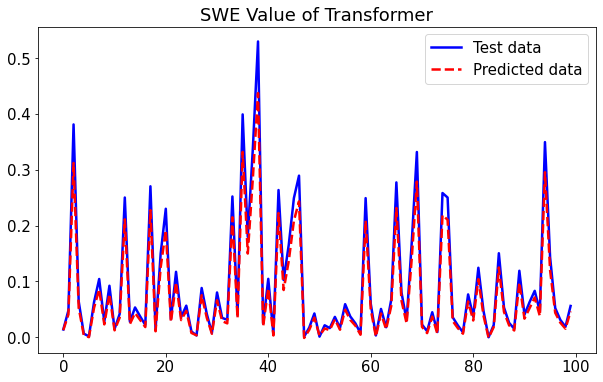

In [8]:
plt.figure(figsize=(10, 6))
# plt.plot(Y_pred[:,1], label='q_predicted')
# plt.plot(Y_train[:,1], label='q')
plt.plot(Yt_test[:100,], 'b-', linewidth=2.5, label='Test data')
plt.plot(Yt_test_pred[:, -1][:100,], 'r--', linewidth=2.5, label='Predicted data')
# plt.plot(Y_test, 'r--', linewidth=2.5, label='Test data')
plt.title("SWE Value of Transformer")
plt.legend()
plt.show()

## 2. LSTM

Reference - [`LSTM` ](http://colah.github.io/posts/2015-08-Understanding-LSTMs/).  

I used a simple model with three LSTM layers and one dense layer. The input is a time series, and the output is SWE values. Input to the model includes features such as  - snow density, snow depth, etc in ten-time stamps. This implementation is simple time series forecasting using the LSTM model.

In [9]:
# LSTM
Xl, Yl = get_lstm_data(canada_train_data_path, 10)
Xl_train, Yl_train = Xl, Yl[:,-1,:]
print(Xl_train.shape, Yl_train.shape)

Xl_v, Yl_v = get_lstm_data(canada_val_data_path, 10)
Xl_val, Yl_val = Xl_v, Yl_v[:,-1,:]
print(Xl_val.shape, Yl_val.shape)

Xl_t, Yl_t = get_lstm_data(canada_test_data_path, 10)
Xl_test, Yl_test = Xl_t, Yl_t[:,-1,:]
print(Xl_test.shape, Yl_test.shape)

(77133, 10, 15) (77133, 1)
(76827, 10, 15) (76827, 1)
(76899, 10, 15) (76899, 1)


In [11]:
n_neuron = 10
input_shape = (Xl_train.shape[1],Xl_train.shape[2])
y_out = Yl_train.shape[-1]

In [12]:
# Fetching LSTM model
lstm_model = get_lstm_model(n_neuron, input_shape, y_out)

# This model is loaded using the most optimized weights
lstm_model.load_weights('best_models/lstm_best_model.h5')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 15)]          0         
                                                                 
 lstm (LSTM)                 (None, 10, 10)            1040      
                                                                 
 lstm_1 (LSTM)               (None, 10, 10)            840       
                                                                 
 lstm_2 (LSTM)               (None, 10)                840       
                                                                 
 dense_24 (Dense)            (None, 1)                 11        
                                                                 
Total params: 2,731
Trainable params: 2,731
Non-trainable params: 0
_________________________________________________________________


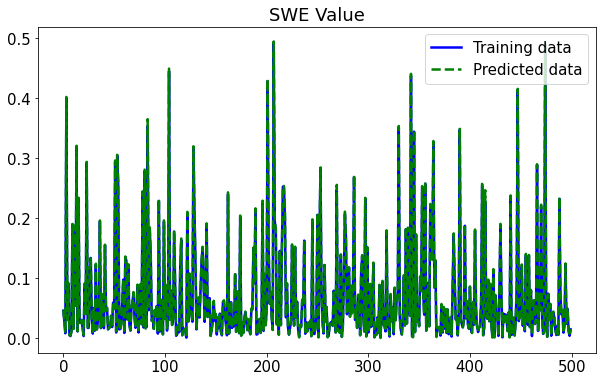

In [14]:
Yl_pred = lstm_model.predict(Xl_train)
plt.figure(figsize=(10, 6))
# plt.plot(Y_pred[:,1], label='q_predicted')
# plt.plot(Y_train[:,1], label='q')
plt.plot(Yl_train[:500,], 'b-', linewidth=2.5, label='Training data')
plt.plot(Yl_pred[:500,], 'g--', linewidth=2.5, label='Predicted data')
# plt.plot(Y_test, 'r--', linewidth=2.5, label='Test data')
plt.title("SWE Value")
plt.legend()
plt.show()

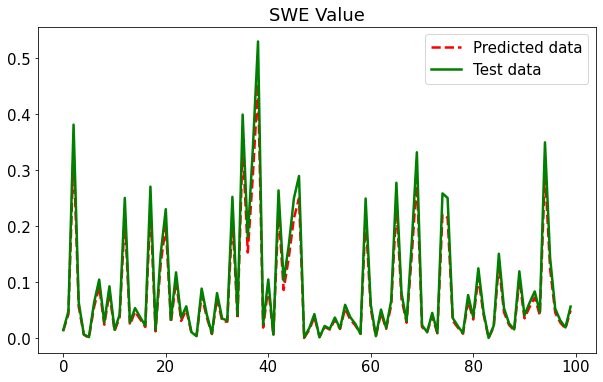

In [15]:
Yl_pred_test = lstm_model.predict(Xl_test)
plt.figure(figsize=(10, 6))
# plt.plot(Y_pred[:,1], label='q_predicted')
# plt.plot(Y_train[:,1], label='q')
# plt.plot(Y_train[:100,], 'b-', linewidth=2.5, label='Training data')
plt.plot(Yl_pred_test[:100,], 'r--', linewidth=2.5, label='Predicted data')
plt.plot(Yl_test[:100], 'g-', linewidth=2.5, label='Test data')
plt.title("SWE Value")
plt.legend()
plt.show()

### Performance:

* In the implementation of the LSTM, the loss = 1.7187e-06 with val_loss = 6.3943e-04. The model captured the overall nonlinear relationship between the predictors and predictand. The model's loss and deviation are slightly lower than the transformer model.
* In the implementation of the transformer, the loss = 6.0696e-06 with val_loss = 4.8880e-04. The model captured the overall nonlinear relationship between the predictors and predictand. The model's loss and deviation are slightly higher than the transformer model.Due to the parallel nature of the transformer, the transformer takes less time than LSTM to train.

<img src="images/obs.png" width="800" height = "500">